# POLI 175 - Lecture 15

## Tree-based models

# Tree-based methods III

## Libraries

In [ ]:
# Packages (just in case you haven't installed)
#using Pkg
#Pkg.add("XGBoost"); Pkg.add("MLJXGBoostInterface")
#Pkg.add("ScikitLearn"); Pkg.add("MLJScikitLearnInterface")
#Pkg.add("LIBSVM"); Pkg.add("MLJLIBSVMInterface")

## Class Examples

In [4]:
## Packages Here
using DataFrames
using MLJ, MLJIteration
import MLJLinearModels, MLJBase, MLJModels
import MultivariateStats, MLJMultivariateStatsInterface
import CSV, Plots, GLM, StatsBase, Random
import LaTeXStrings, StatsPlots, Lowess, Gadfly, RegressionTables
import CovarianceMatrices, Econometrics, LinearAlgebra, MixedModelsExtras
import Missings, StatsAPI, FreqTables, EvalMetrics
import NearestNeighborModels

# Decision tree stuff
import MLJDecisionTreeInterface, DecisionTree, GraphViz, EvoTrees

# Ensemble stuff
import XGBoost, MLJXGBoostInterface

# Adapted from @xiaodaigh: https://github.com/xiaodaigh/DataConvenience.jl
function onehot!(df::AbstractDataFrame, 
        col, cate = sort(unique(df[!, col])); 
        outnames = Symbol.(col, :_, cate))
    transform!(df, @. col => ByRow(isequal(cate)) .=> outnames)
end

onehot! (generic function with 2 methods)

## Class Examples

In [5]:
## Loading the data
chile = CSV.read(
    download("https://raw.githubusercontent.com/umbertomig/POLI175julia/main/data/chilesurvey.csv"), 
    DataFrame,
    missingstring = ["NA"]
); dropmissing!(chile)
chile.voteyes = ifelse.(chile.vote .== "Y", 1, 0)

# One-hot encoding (we will learn a better way to do it later)
onehot!(chile, :region);
onehot!(chile, :education);
onehot!(chile, :sex);

# Drop reference categories
select!(chile, Not(:region, :income, :population, :sex, :education, :region_C, :education_P, :sex_M))

# Checking
first(chile, 3)

Row,age,statusquo,vote,voteyes,region_M,region_N,region_S,region_SA,education_PS,education_S,sex_F
,Int64,Float64,String1,Int64,Bool,Bool,Bool,Bool,Bool,Bool,Bool
1,65,1.0082,Y,1,false,true,false,false,false,false,false
2,29,-1.29617,N,0,false,true,false,false,true,false,false
3,38,1.23072,Y,1,false,true,false,false,false,false,true


## Class Examples

In [6]:
## Answers here
y, X = unpack(
    chile[:, ["voteyes", "age", "statusquo", "education_S", "education_PS"]], 
    ==(:voteyes);                  ## Target (all else features...)
    :voteyes       => Multiclass,  ## Var types
    :age           => Continuous,
    :statusquo     => Continuous,
    :education_S   => Multiclass,
    :education_PS  => Multiclass
);

train, test = partition(
    eachindex(y),   ## Index with the eachindex(.) method
    0.75,           ## Proportion in the training set
    shuffle = true, ## Shuffle the data
    stratify = y,
    rng = 92837     ## Random seed (ensure same results; not necessary)
);

## Bagging (Bootstrap Aggregation)

## Bagging

- Bagging stands for Bootstrap Aggregation.

- The idea is to fit each tree on a bootstrapped dataset, then take the average of all trees.

- Each tree performs poorly. However, the average performance of all of them is better!

$$ \hat{f}_{bag}(x) \ = \ \dfrac{1}{B}\sum_{b = 1}^B \hat{f}^b(x) $$

## Bagging

![bag1](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/bag1.png?raw=true)

## Bagging

In [8]:
# Decision tree
tree_model = MLJDecisionTreeInterface.DecisionTreeClassifier();

# Instantiate the machine
bagging = EnsembleModel(model = tree_model, n = 50)

ProbabilisticEnsembleModel(
  model = DecisionTreeClassifier(
        max_depth = -1, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_purity_increase = 0.0, 
        n_subfeatures = 0, 
        post_prune = false, 
        merge_purity_threshold = 1.0, 
        display_depth = 5, 
        feature_importance = :impurity, 
        rng = Random._GLOBAL_RNG()), 
  atomic_weights = Float64[], 
  bagging_fraction = 0.8, 
  rng = Random._GLOBAL_RNG(), 
  n = 50, 
  acceleration = CPU1{Nothing}(nothing), 
  out_of_bag_measure = Any[])

## Bagging

In [9]:
# Fit the machine
mach = machine(bagging, X, y, scitype_check_level=0);
fit!(mach, rows = train);

# Compute the predictions
y_pred_mode_bag = predict_mode(mach, rows = test);
y_pred_prob_bag = pdf.(predict(mach, rows = test), 1);

[ Info: Training machine(ProbabilisticEnsembleModel(model = DecisionTreeClassifier(max_depth = -1, …), …), …).
Training ensemble: 100%[==================================================] Time: 0:00:01


## Bagging

In [10]:
accuracy(y_pred_mode_bag, y[test])

0.787828947368421

In [11]:
f1score(y_pred_mode_bag, y[test])

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


0.6814814814814815

In [12]:
confusion_matrix(y_pred_mode_bag, y[test])

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 341  │  71  │
├─────────┼──────┼──────┤
│    1    │  58  │ 138  │
└─────────┴──────┴──────┘


## Bagging

┌ Warning: The closest lower feasible false positive rate to some of the required values (0.0033444816053511705, 0.006688963210702341, 0.010033444816053512, 0.013377926421404682, 0.016722408026755852) is 0.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:152
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149


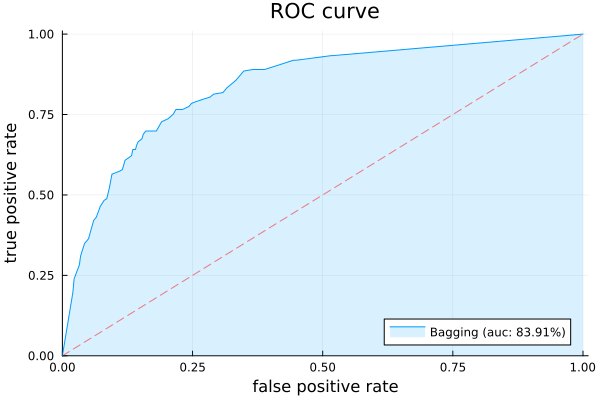

In [13]:
# ROC Curve
EvalMetrics.rocplot(Vector{Int64}(y[test]), y_pred_prob_bag, label = "Bagging", diagonal = true)

## Random Forests

- It is **not** a place where data scientists go camping.

- Random forests intend to improve the effectiveness of our bagging estimates.

- Each bagging tree in the ensemble can be highly correlated with each other.
    - This messes up the prediction because it reduces the contribution of each tree.

- To fix that, we tweak the bagging to *decorrelate* the trees.

## Random Forests

- A simple way to do that is only to consider a subset of the predictors at each tree.
    - Why would we even want to do that?
    
- Let a strong predictor with a bunch of other weak ones. Then:
    1. All bagging trees will rely on the stronger predictor more than the others.
    2. Subsetting the number of variables, considering subsets where the strong predictor is not there, improves the usage of the weak predictors.
        - This *decorrelates* the trees!

- Rule of thumb: Use $m = \sqrt{p}$ predictors at a time.

## Random Forests

- Choose a small(er) $m$ if the predictors are all highly correlated.

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/rf1.png?raw=true)

## Random Forests

In [14]:
# Random Forest Classifier
rf_model = MLJDecisionTreeInterface.RandomForestClassifier()

RandomForestClassifier(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 100, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

## Random Forests

In [15]:
# Fit the machine
mach = machine(rf_model, X, y, scitype_check_level=0);
fit!(mach, rows = train);

# Compute the predictions
y_pred_mode_rf = predict_mode(mach, rows = test);
y_pred_prob_rf = pdf.(predict(mach, rows = test), 1);

[ Info: Training machine(RandomForestClassifier(max_depth = -1, …), …).


## Random Forests

In [16]:
accuracy(y_pred_mode_rf, y[test])

0.7960526315789473

In [17]:
f1score(y_pred_mode_rf, y[test])

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


0.696078431372549

In [18]:
confusion_matrix(y_pred_mode_rf, y[test])

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 342  │  67  │
├─────────┼──────┼──────┤
│    1    │  57  │ 142  │
└─────────┴──────┴──────┘


## Bagging

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149


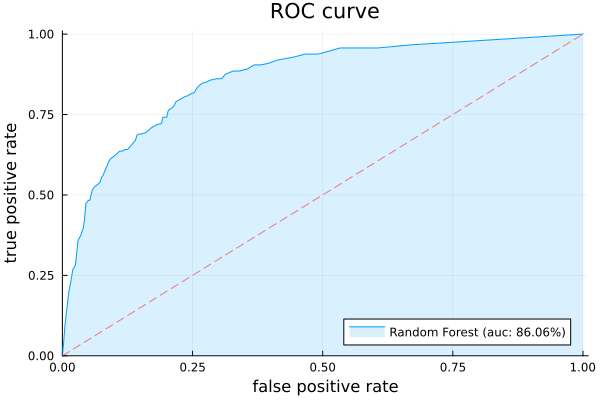

In [19]:
# ROC Curve
EvalMetrics.rocplot(Vector{Int64}(y[test]), y_pred_prob_rf, label = "Random Forest", diagonal = true)

## Boosting

- Ensemble method that combines weak learners to form a stronger one.
    + Example: Regression tree that is only allowed to have one leaf!

- It builds on accumulation: Every predictor tries to improve the predecessor's job.
    - Work with the errors of the previous models, and update the fit slowly.

## Boosting

**Algorithm:** Start with a null model ($\hat{f}(x) = 0$), the residual equals to $r_i = y_i$, and a number $B$ of steps.

For each $b \in \{1, 2, \cdots, B\}$:

1. Fit a tree $\hat{f}^b(x)$ with $d$ splits (or d+1 terminal nodes).

2. Set:

$$ \hat{f}_{new}(x) = \hat{f}_{old}(x) + \lambda \hat{f}^b(x) $$

3. Set 

$$ r_{i_{new}} = r_{i_{old}} - \lambda \hat{f}^b(x) $$

At the end, you should define $\hat{f}(x)$ as:

$$ \hat{f}(x) = \sum_{b=1}^B \lambda \hat{f}^b(x) $$

## Boosting

- You can overfit using boosting. But only if $B$ is too large.

- $\lambda$: Controls the rate that your boosting algorithm is learning.
    + Small $\lambda$s require large $B$s

- $d$: Controls the complexity of each step. $d=1$ tends to work well!

## Boosting

![imgb](https://upload.wikimedia.org/wikipedia/commons/b/b5/Ensemble_Boosting.svg)

## Adaptive Boosting (AdaBoost)

In [20]:
# AdaBoostStump
adaboost_model = MLJDecisionTreeInterface.AdaBoostStumpClassifier()

AdaBoostStumpClassifier(
  n_iter = 10, 
  feature_importance = :impurity, 
  rng = Random._GLOBAL_RNG())

## AdaBoost

In [21]:
# Fit the machine
mach = machine(adaboost_model, X, y, scitype_check_level=0);
fit!(mach, rows = train);

# Compute the predictions
y_pred_mode_adaboost = predict_mode(mach, rows = test);
y_pred_prob_adaboost = pdf.(predict(mach, rows = test), 1);

[ Info: Training machine(AdaBoostStumpClassifier(n_iter = 10, …), …).


## AdaBoost

In [22]:
accuracy(y_pred_mode_adaboost, y[test])

0.8141447368421053

In [23]:
f1score(y_pred_mode_adaboost, y[test])

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/hPDX2/src/confusion_matrices.jl:339


0.7153652392947103

In [24]:
confusion_matrix(y_pred_mode_adaboost, y[test])

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 353  │  67  │
├─────────┼──────┼──────┤
│    1    │  46  │ 142  │
└─────────┴──────┴──────┘


## Bagging

┌ Warning: The closest lower feasible false positive rate to some of the required values (0.0033444816053511705) is 0.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:152
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149


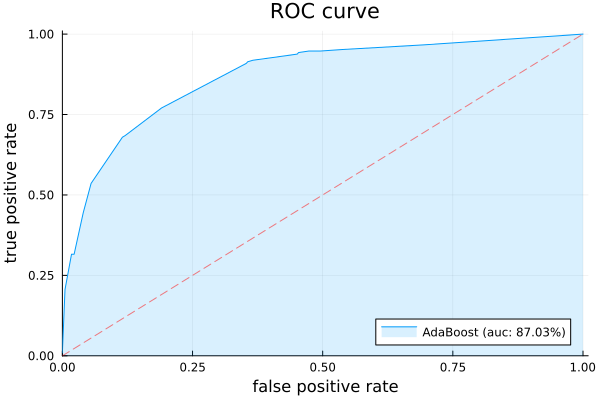

In [25]:
# ROC Curve
EvalMetrics.rocplot(Vector{Int64}(y[test]), y_pred_prob_adaboost, label = "AdaBoost", diagonal = true)

## How do they compare?

We can plot a ROC curve with all of them:

┌ Warning: The closest lower feasible false positive rate to some of the required values (0.0033444816053511705, 0.006688963210702341, 0.010033444816053512, 0.013377926421404682, 0.016722408026755852) is 0.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:152
┌ Warning: The closest lower feasible false positive rate to some of the required values (0.0033444816053511705) is 0.0!
└ @ EvalMetrics ~/.julia/packages/EvalMetrics/ONIFL/src/thresholds.jl:152
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/pa

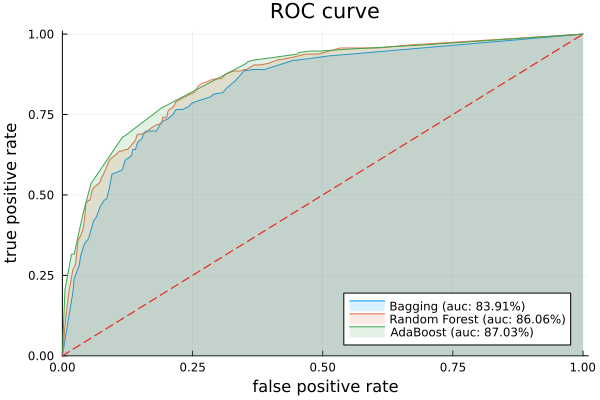

In [26]:
# ROC Curve
EvalMetrics.rocplot(
    [Vector{Int64}(y[test]), Vector{Int64}(y[test]), Vector{Int64}(y[test])], 
    [y_pred_prob_bag, y_pred_prob_rf, y_pred_prob_adaboost], 
    label = ["Bagging" "Random Forest" "AdaBoost";], diagonal = true)

# Questions?

# See you next class
